In [107]:
import json
import numpy as np
import pandas as pd
from typing import List, Dict
from copy import deepcopy
import xml.etree.ElementTree as ET
from xml.dom import minidom

# Словарь для нормализации названий предметов
SUBJECT_MAPPING = {
    'Английский': 'Английский язык',
    'Немецкий': 'Немецкий язык',
    'Французский': 'Французский язык',
    'Испанский': 'Испанский язык',
    'Итальянский': 'Итальянский язык',
    'Китайский': 'Китайский язык',
    'Японский': 'Японский язык',
    'Корейский': 'Корейский язык',
    'Турецкий': 'Турецкий язык',
    'Арабский': 'Арабский язык',
    'Польский': 'Польский язык',
    'Чешский': 'Чешский язык',
    'Казахский': 'Казахский язык',
    'Русский': 'Русский язык',
    'Украинский': 'Украинский язык',
    'Химия': 'Химия',
    'Физика': 'Физика',
    'Математика': 'Математика',
    'Информатика': 'Информатика',
}

def normalize_subject(subject: str) -> str:
    """Нормализация названия предмета"""
    subject = subject.strip()
    return SUBJECT_MAPPING.get(subject, subject)

def normalize_subjects(subjects: List[str]) -> List[str]:
    """Нормализация списка предметов"""
    normalized = []
    for s in subjects:
        norm = normalize_subject(s)
        if norm and norm not in normalized:
            normalized.append(norm)
    return normalized

def remove_price_outliers(data: List[Dict]) -> tuple:
    prices = np.array([item['price'] for item in data if item.get('price')])
    
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\nPrice statistics:")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    
    valid_items = []
    removed = 0
    
    for item in data:
        price = item.get('price')
        if price and lower_bound <= price <= upper_bound:
            valid_items.append(item)
        else:
            removed += 1
    
    return valid_items, removed

def clean_invalid_records(data: List[Dict]) -> tuple:
    valid_items = []
    removed = 0
    
    for item in data:
        price = item.get('price')
        subjects = item.get('subjects', [])
        
        if price and price > 0 and len(subjects) > 0:
            valid_items.append(item)
        else:
            removed += 1
            
    return valid_items, removed

def make_hashable(item: Dict) -> tuple:
    def convert_value(v):
        if isinstance(v, list):
            return tuple(sorted(str(x) for x in v))
        if isinstance(v, dict):
            return make_hashable(v)
        return v
    return tuple((k, convert_value(v)) for k, v in sorted(item.items()))

def find_duplicates(data: List[Dict]) -> tuple:
    unique_items = []
    seen = set()
    duplicates = 0
    
    for item in data:
        item_tuple = make_hashable(item)
        if item_tuple not in seen:
            seen.add(item_tuple)
            unique_items.append(item)
        else:
            duplicates += 1
    
    return unique_items, duplicates

def process_data(data: List[Dict]) -> List[Dict]:
    working_data = deepcopy(data)
    
    print("Removing invalid records")
    cleaned_data, invalid_count = clean_invalid_records(working_data)
    print(f"Invalid records removed: {invalid_count}")
    
    print("\nRemoving price outliers")
    no_outliers_data, outliers_count = remove_price_outliers(cleaned_data)
    print(f"Price outliers removed: {outliers_count}")
    
    print("\nRemoving duplicates")
    final_data, dupes = find_duplicates(no_outliers_data)
    print(f"Duplicates removed: {dupes}")
    
    print(f"\nSummary:")
    print(f"Original records: {len(data)}")
    print(f"Final records: {len(final_data)}")
    
    return final_data

In [109]:
# Загрузка данных
with open('buki_tutors_data.json', 'r', encoding='utf-8') as f:
    buki_data = json.load(f)

with open('preply_tutors_data.json', 'r', encoding='utf-8') as f:
    preply_data = json.load(f)

print(f"Buki records: {len(buki_data)}")
print(f"Preply records: {len(preply_data)}")
print(f"Total: {len(buki_data) + len(preply_data)}")

Buki records: 3002
Preply records: 295
Total: 3297


In [110]:
# Нормализация и объединение данных
def prepare_buki(data):
    result = []
    for item in data:
        result.append({
            'subjects': normalize_subjects(item.get('subjects', [])),
            'price': item.get('price'),
            'rating': item.get('rating', 0),
            'reviewCount': item.get('reviewCount', 0),
            'shortDescription': item.get('shortDescription', ''),
            'canWorkOnline': item.get('canWorkOnline', False),
            'isVerified': item.get('isVerified', False),
            'location': item.get('city'),
            'education': item.get('education'),
            'experience': item.get('experience'),
            'source': 'Buki'
        })
    return result

def prepare_preply(data):
    result = []
    for item in data:
        result.append({
            'subjects': normalize_subjects(item.get('subjects', [])),
            'price': item.get('price'),
            'rating': item.get('rating', 0),
            'reviewCount': item.get('reviewCount', 0),
            'shortDescription': item.get('shortDescription', ''),
            'canWorkOnline': item.get('canWorkOnline', True),
            'isVerified': item.get('isVerified', False),
            'location': item.get('country'),
            'education': None,
            'experience': None,
            'source': 'Preply'
        })
    return result

buki_prepared = prepare_buki(buki_data)
preply_prepared = prepare_preply(preply_data)

# Объединение
combined_data = buki_prepared + preply_prepared
print(f"Combined records: {len(combined_data)}")

Combined records: 3297


In [111]:
# Очистка данных
print("Buki data")
buki_clean = process_data(buki_prepared)

print("Preply data")
preply_clean = process_data(preply_prepared)

# Финальное объединение
clean_data = buki_clean + preply_clean
clean_data, cross_dupes = find_duplicates(clean_data)

print("Final dataset")
print(f"Buki: {len(buki_clean)}")
print(f"Preply: {len(preply_clean)}")
print(f"Cross-duplicates removed: {cross_dupes}")
print(f"Total clean records: {len(clean_data)}")

Buki data
Removing invalid records
Invalid records removed: 0

Removing price outliers

Price statistics:
Q1: 3000.00
Q3: 5000.00
IQR: 2000.00
Lower bound: 0.00
Upper bound: 8000.00
Price outliers removed: 209

Removing duplicates
Duplicates removed: 0

Summary:
Original records: 3002
Final records: 2793
Preply data
Removing invalid records
Invalid records removed: 0

Removing price outliers

Price statistics:
Q1: 6087.00
Q3: 10905.50
IQR: 4818.50
Lower bound: -1140.75
Upper bound: 18133.25
Price outliers removed: 14

Removing duplicates
Duplicates removed: 0

Summary:
Original records: 295
Final records: 281
Final dataset
Buki: 2793
Preply: 281
Cross-duplicates removed: 0
Total clean records: 3074


In [113]:
# Сохранение в JSON
with open('cleaned_data/tutors_cleaned.json', 'w', encoding='utf-8') as f:
    json.dump(clean_data, f, ensure_ascii=False, indent=2)
print(f"Saved to tutors_cleaned.json ({len(clean_data)} records)")

# Сохранение в CSV
df = pd.DataFrame(clean_data)
df['subjects_str'] = df['subjects'].apply(lambda x: '; '.join(x) if x else '')
df_csv = df.drop(columns=['subjects']).rename(columns={'subjects_str': 'subjects'})
cols = ['subjects', 'price', 'rating', 'reviewCount', 'shortDescription', 
        'canWorkOnline', 'isVerified', 'location', 'education', 'experience', 'source']
df_csv[cols].to_csv('cleaned_data/tutors_combined.csv', index=False, encoding='utf-8-sig')
print(f"Saved to tutors_combined.csv")

# Сохранение в XML
root = ET.Element('tutors', total=str(len(clean_data)))
for item in clean_data:
    tutor = ET.SubElement(root, 'tutor')
    for key, value in item.items():
        child = ET.SubElement(tutor, key)
        if isinstance(value, list):
            child.text = '; '.join(str(v) for v in value)
        elif value is not None:
            child.text = str(value)

xml_str = minidom.parseString(ET.tostring(root)).toprettyxml(indent='  ')
with open('cleaned_data/tutors_combined.xml', 'w', encoding='utf-8') as f:
    f.write(xml_str)
print(f"Saved to tutors_combined.xml")

Saved to tutors_cleaned.json (3074 records)
Saved to tutors_combined.csv
Saved to tutors_combined.xml


In [114]:
# Создание DataFrame для анализа
df = pd.DataFrame(clean_data)

# Ценовые сегменты
q1, q2, q3 = df['price'].quantile([0.25, 0.5, 0.75])

def get_segment(price):
    if price <= q1: return 'Low-priced'
    elif price <= q2: return 'Middle-priced'
    elif price <= q3: return 'High-priced'
    else: return 'Luxury'

df['price_segment'] = df['price'].apply(get_segment)

print("Price Segment Boundaries:")
print(f"Low-priced: <= {q1:.0f}")
print(f"Middle-priced: {q1:.0f} - {q2:.0f}")
print(f"High-priced: {q2:.0f} - {q3:.0f}")
print(f"Luxury: > {q3:.0f}")
print(f"\nSegment Distribution:")
print(df['price_segment'].value_counts())

Price Segment Boundaries:
Low-priced: <= 3000
Middle-priced: 3000 - 4000
High-priced: 4000 - 5000
Luxury: > 5000

Segment Distribution:
price_segment
Low-priced       1006
Middle-priced     891
Luxury            622
High-priced       555
Name: count, dtype: int64


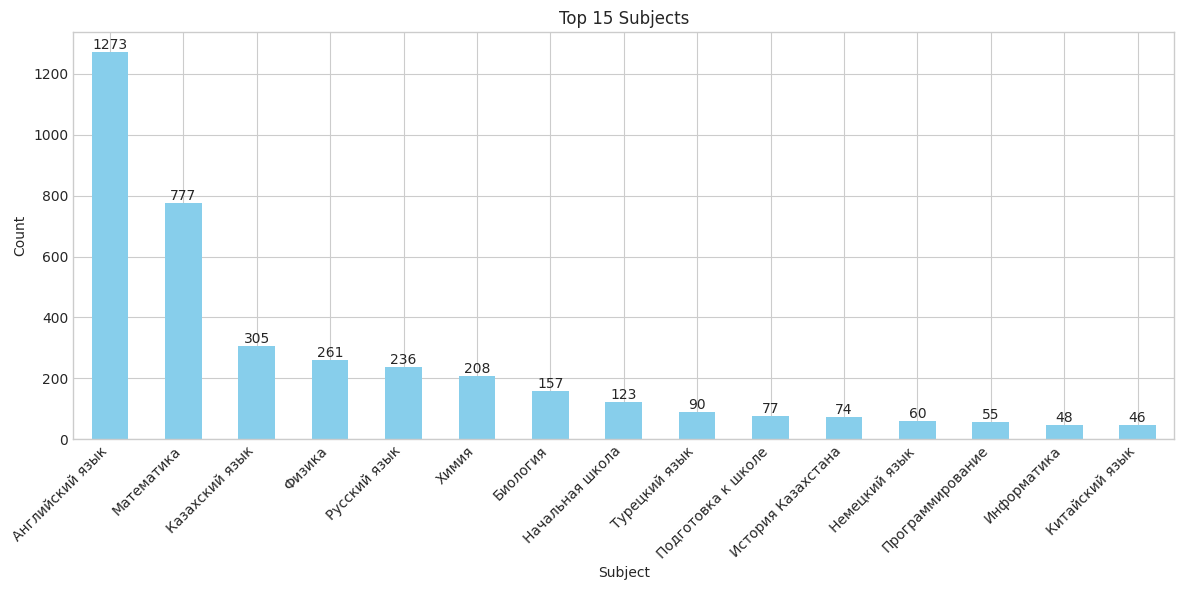

In [115]:
import matplotlib.pyplot as plt

# Топ-15 предметов
subjects = df.explode('subjects')['subjects'].value_counts().head(15)

plt.figure(figsize=(12, 6))
ax = subjects.plot(kind='bar', color='skyblue')
plt.title('Top 15 Subjects')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(subjects):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/subjects_distribution.png', dpi=150)
plt.show()

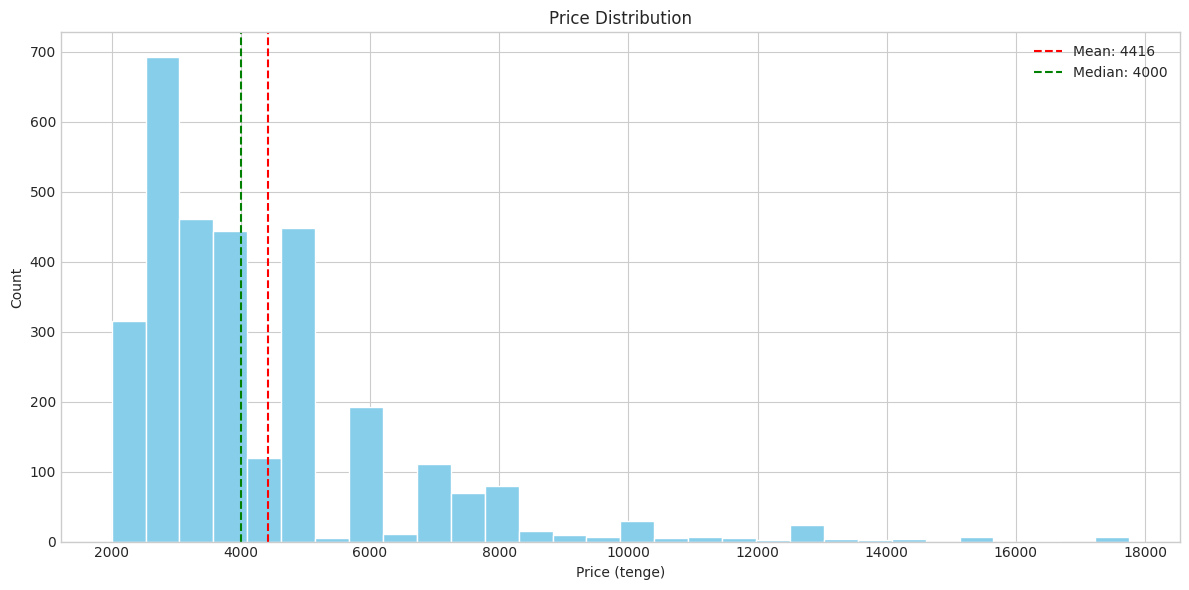

In [116]:
# Распределение цен
plt.figure(figsize=(12, 6))
plt.hist(df['price'], bins=30, color='skyblue', edgecolor='white')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: {df["price"].mean():.0f}')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: {df["price"].median():.0f}')
plt.title('Price Distribution')
plt.xlabel('Price (tenge)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('img/price_distribution.png', dpi=150)
plt.show()

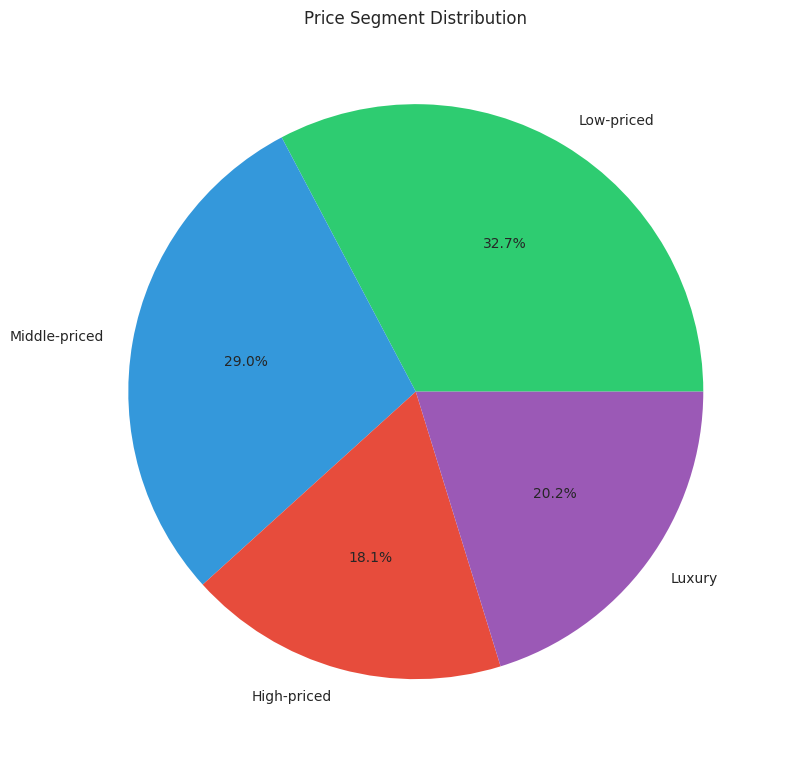

In [117]:
# Распределение по сегментам
segment_order = ['Low-priced', 'Middle-priced', 'High-priced', 'Luxury']
colors = {'Low-priced': '#2ecc71', 'Middle-priced': '#3498db', 'High-priced': '#e74c3c', 'Luxury': '#9b59b6'}

segment_counts = df['price_segment'].value_counts().reindex(segment_order)

plt.figure(figsize=(8, 8))
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        colors=[colors[s] for s in segment_counts.index])
plt.title('Price Segment Distribution')
plt.tight_layout()
plt.savefig('img/segment_pie.png', dpi=150)
plt.show()

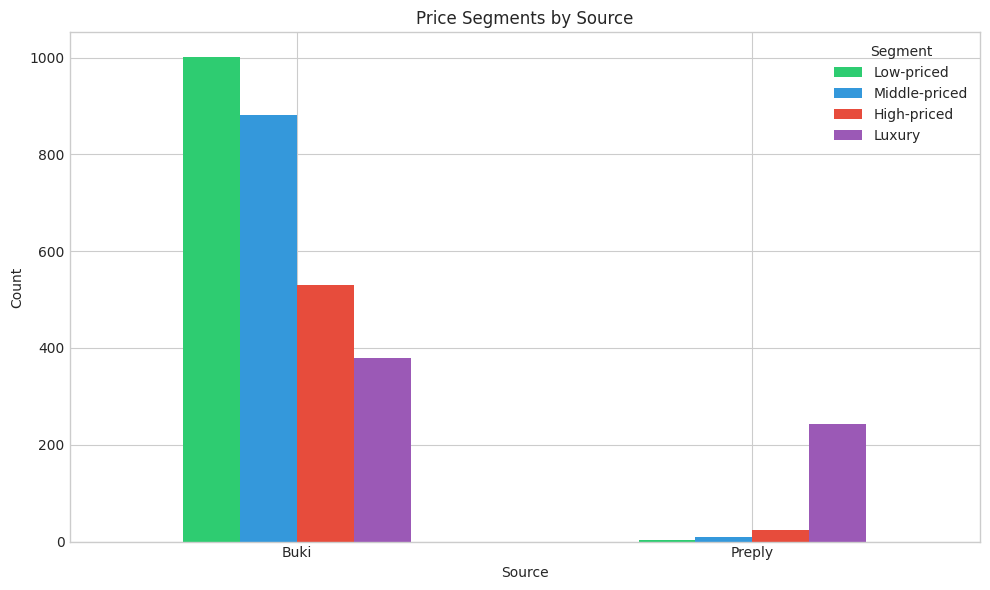

In [118]:
# Сегменты по источникам
source_segment = df.groupby(['source', 'price_segment']).size().unstack(fill_value=0)
source_segment = source_segment[segment_order]

ax = source_segment.plot(kind='bar', color=[colors[s] for s in segment_order], figsize=(10, 6))
plt.title('Price Segments by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Segment')
plt.tight_layout()
plt.savefig('img/segments_by_source.png', dpi=150)
plt.show()

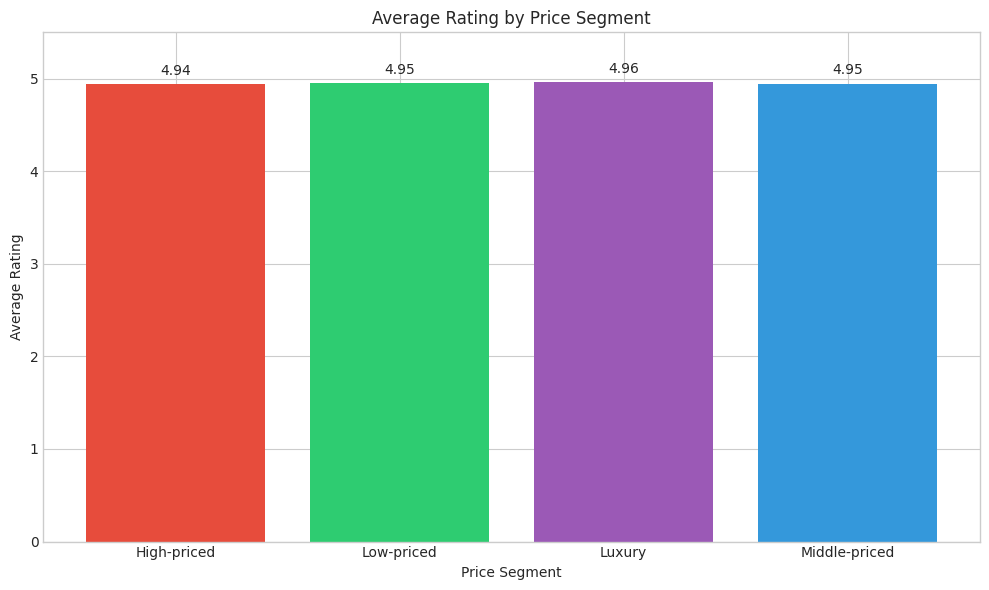

In [130]:
# Средний рейтинг по сегментам
df_with_rating = df[df['rating'] > 0]
avg_rating = df_with_rating.groupby('price_segment')['rating'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(avg_rating.index, avg_rating.values, color=[colors[s] for s in avg_rating.index])
plt.title('Average Rating by Price Segment')
plt.xlabel('Price Segment')
plt.ylabel('Average Rating')
plt.ylim(0, 5.5)

for bar, val in zip(bars, avg_rating.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}', ha='center')

plt.tight_layout()
plt.savefig('img/rating_by_segment.png', dpi=150)
plt.show()

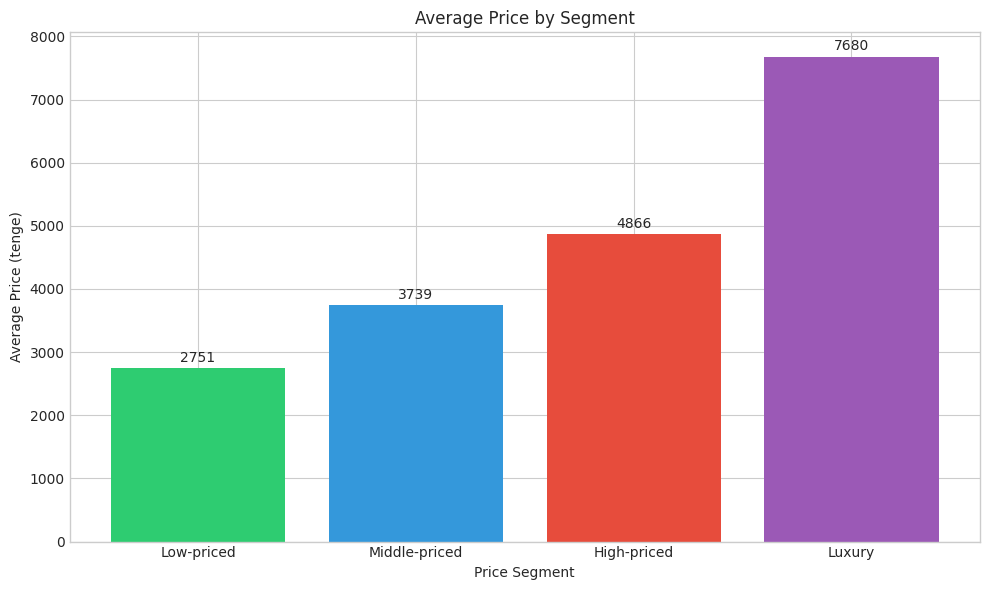

In [121]:
# Средняя цена по сегментам
avg_price = df.groupby('price_segment')['price'].mean().reindex(segment_order)

plt.figure(figsize=(10, 6))
bars = plt.bar(avg_price.index, avg_price.values, color=[colors[s] for s in avg_price.index])
plt.title('Average Price by Segment')
plt.xlabel('Price Segment')
plt.ylabel('Average Price (tenge)')

for bar, val in zip(bars, avg_price.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{val:.0f}', ha='center')

plt.tight_layout()
plt.savefig('img/price_by_segment.png', dpi=150)
plt.show()

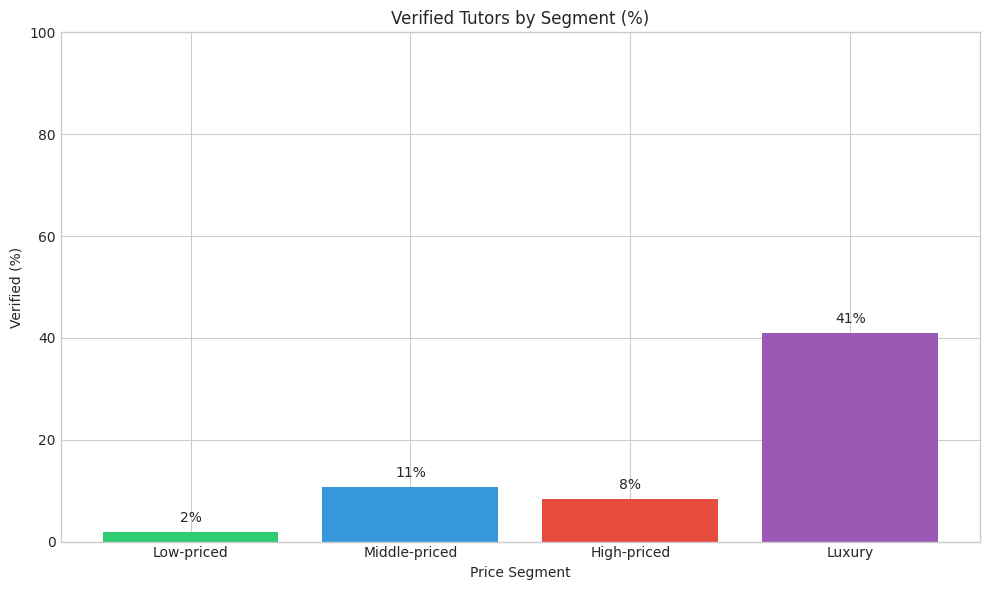

In [122]:
# Верификация по сегментам
verified = df.groupby('price_segment')['isVerified'].mean().reindex(segment_order) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(verified.index, verified.values, color=[colors[s] for s in verified.index])
plt.title('Verified Tutors by Segment (%)')
plt.xlabel('Price Segment')
plt.ylabel('Verified (%)')
plt.ylim(0, 100)

for bar, val in zip(bars, verified.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}%', ha='center')

plt.tight_layout()
plt.savefig('img/verified_by_segment.png', dpi=150)
plt.show()

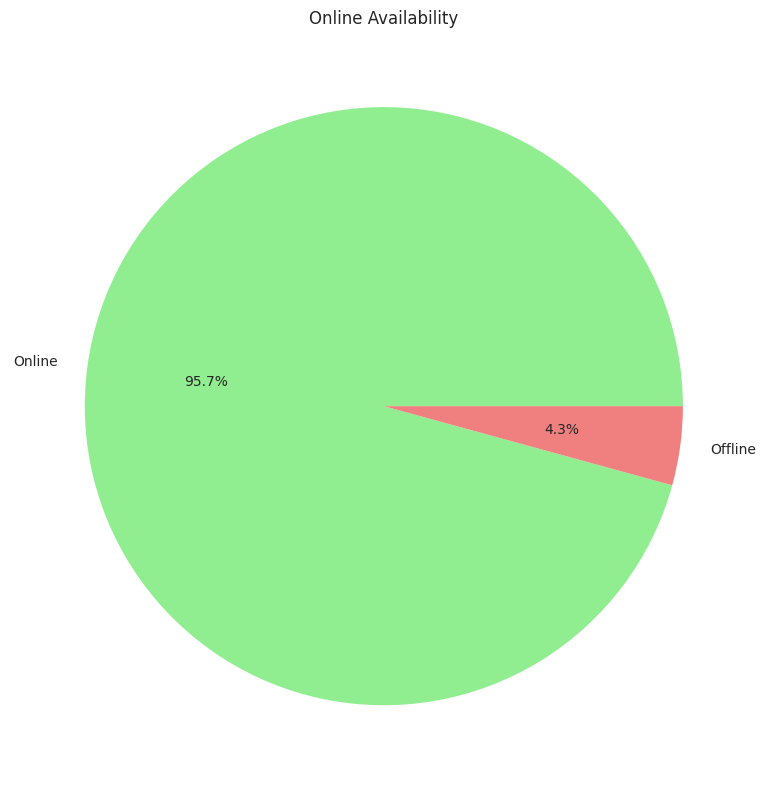

In [ ]:
# Online availability
online = df['canWorkOnline'].value_counts()
print(online)

plt.figure(figsize=(8, 8))
plt.pie(online.values, labels=['Online', 'Offline'] if online.index[0] else ['Offline', 'Online'],
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Online Availability')
plt.tight_layout()
plt.savefig('img/online_availability.png', dpi=150)
plt.show()

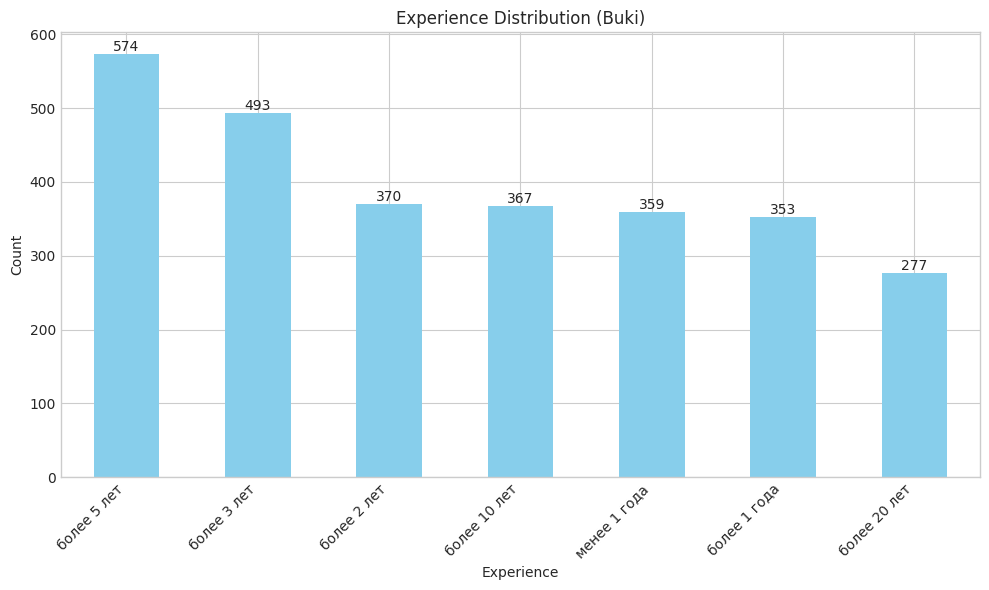

In [124]:
# Опыт (только Buki)
buki_df = df[df['source'] == 'Buki']
exp_counts = buki_df['experience'].value_counts()

plt.figure(figsize=(10, 6))
ax = exp_counts.plot(kind='bar', color='skyblue')
plt.title('Experience Distribution (Buki)')
plt.xlabel('Experience')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(exp_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/experience_distribution.png', dpi=150)
plt.show()

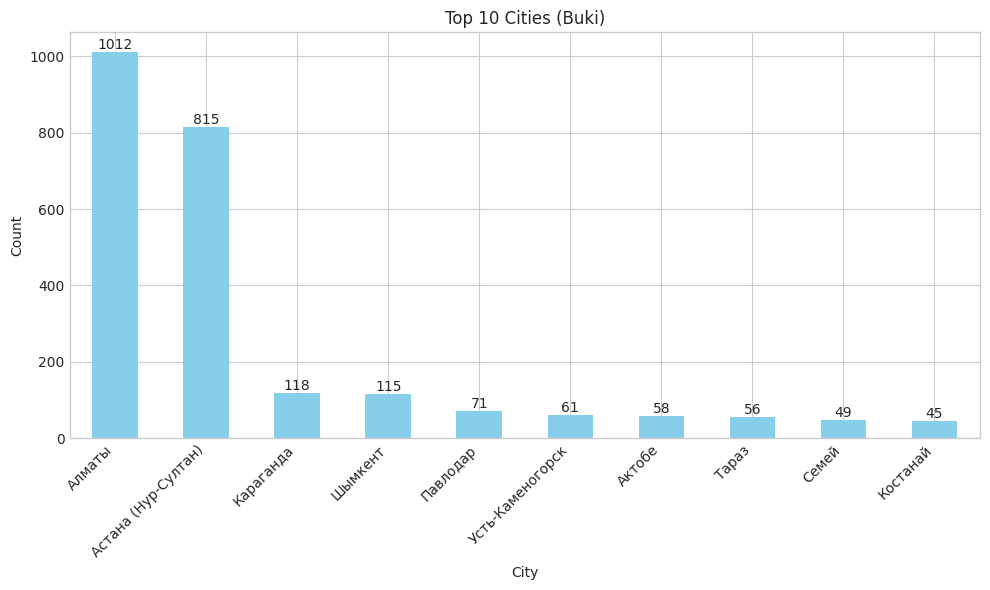

In [125]:
# Города (только Buki)
city_counts = buki_df['location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = city_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities (Buki)')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(city_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/city_distribution.png', dpi=150)
plt.show()

In [ ]:
# Сводная статистика по сегментам
summary = df.groupby('price_segment').agg({
    'price': ['count', 'mean', 'min', 'max'],
    'rating': 'mean',
    'reviewCount': 'mean',
    'isVerified': 'mean'
}).round(2)

summary.columns = ['Count', 'Avg Price', 'Min Price', 'Max Price', 'Avg Rating', 'Avg Reviews', 'Verified %']
summary['Verified %'] = (summary['Verified %'] * 100).round(1)
summary = summary.reindex(segment_order)

print(summary.to_string())

               Count  Avg Price  Min Price  Max Price  Avg Rating  Avg Reviews  Verified %
price_segment                                                                             
Low-priced      1006    2750.63       2000       3000        0.88         1.34         2.0
Middle-priced    891    3738.94       3043       4000        1.67         2.62        11.0
High-priced      555    4866.12       4058       5000        2.12         4.50         8.0
Luxury           622    7680.10       5072      17753        2.77         6.35        41.0

Saved to segment_statistics.csv


In [128]:
# Детальный анализ по сегментам
for segment in segment_order:
    seg_df = df[df['price_segment'] == segment]
    print(f"\n{segment.upper()}")
    print(f"Count: {len(seg_df)} ({len(seg_df)/len(df)*100:.1f}% of market)")
    print(f"Price range: {seg_df['price'].min():.0f} - {seg_df['price'].max():.0f} tenge")
    print(f"Avg rating: {seg_df['rating'].mean():.2f}")
    print(f"Avg reviews: {seg_df['reviewCount'].mean():.1f}")
    print(f"Verified: {seg_df['isVerified'].mean()*100:.0f}%")
    
    # Топ-3 предмета
    top_subjects = seg_df.explode('subjects')['subjects'].value_counts().head(3)
    print(f"Top subjects: {', '.join(top_subjects.index.tolist())}")
    
    # По источникам
    for src, cnt in seg_df['source'].value_counts().items():
        print(f"  {src}: {cnt} ({cnt/len(seg_df)*100:.0f}%)")


LOW-PRICED
Count: 1006 (32.7% of market)
Price range: 2000 - 3000 tenge
Avg rating: 0.88
Avg reviews: 1.3
Verified: 2%
Top subjects: Английский язык, Математика, Казахский язык
  Buki: 1002 (100%)
  Preply: 4 (0%)

MIDDLE-PRICED
Count: 891 (29.0% of market)
Price range: 3043 - 4000 tenge
Avg rating: 1.67
Avg reviews: 2.6
Verified: 11%
Top subjects: Английский язык, Математика, Казахский язык
  Buki: 881 (99%)
  Preply: 10 (1%)

HIGH-PRICED
Count: 555 (18.1% of market)
Price range: 4058 - 5000 tenge
Avg rating: 2.12
Avg reviews: 4.5
Verified: 8%
Top subjects: Английский язык, Математика, Казахский язык
  Buki: 531 (96%)
  Preply: 24 (4%)

LUXURY
Count: 622 (20.2% of market)
Price range: 5072 - 17753 tenge
Avg rating: 2.77
Avg reviews: 6.4
Verified: 41%
Top subjects: Английский язык, Математика, Русский язык
  Buki: 379 (61%)
  Preply: 243 (39%)


In [129]:
print(f"Total tutors: {len(df)}")
print(f"  Buki: {len(df[df['source']=='Buki'])}")
print(f"  Preply: {len(df[df['source']=='Preply'])}")
print(f"\nPrice:")
print(f"  Mean: {df['price'].mean():.0f} tenge")
print(f"  Median: {df['price'].median():.0f} tenge")
print(f"  Range: {df['price'].min():.0f} - {df['price'].max():.0f} tenge")
print(f"\nQuality:")
print(f"  Avg rating: {df['rating'].mean():.2f}")
print(f"  Avg reviews: {df['reviewCount'].mean():.1f}")
print(f"  Verified: {df['isVerified'].mean()*100:.0f}%")
print(f"  Online: {df['canWorkOnline'].mean()*100:.0f}%")
print(f"\nCorrelation: {df['price'].corr(df['rating']):.3f}")

Total tutors: 3074
  Buki: 2793
  Preply: 281

Price:
  Mean: 4416 tenge
  Median: 4000 tenge
  Range: 2000 - 17753 tenge

Quality:
  Avg rating: 1.71
  Avg reviews: 3.3
  Verified: 13%
  Online: 96%

Correlation: 0.268
